# A computational account of threat-related attentional bias

# Subject parameter value analysis

This notebook performed analyses linking individual subjects' parameter values to questionnaire scores and measures of behavioural tendencies.

In [11]:
import os
import sys
sys.path.insert(0, '../code') 

import numpy as np
import seaborn as sns
import pandas as pd
from bambi import Model
import matplotlib.pyplot as plt
import pymc3 as pm
import json
import re
from modelling_functions import construct_equation
from tqdm import tqdm
import matplotlib
import matplotlib.font_manager as font_manager
prop = font_manager.FontProperties(fname="../figures/fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#267fd3', '#e88300', '#b21724', '#053c5e']

## Process the questionnaire data

Questionnaire data is stored in .json files, so we need to put this into a nicer format.

In [12]:
data_dir = '../data/questionnaire_data'

# Question numbers for the STICSA cognitive factor
sticsa_t_cognitive_qs = [2, 3, 4, 8, 9, 10, 12, 15, 16, 18]

dfs = []

# Put data for each subject into a dataframe
for i in tqdm([j for j in os.listdir(data_dir) if re.match('[0-9]{2}_questionnaire', j)]):
    data = json.load(open(os.path.join(data_dir, i)))
    df = pd.DataFrame(data, index=[0])
    df.columns = ['Subject' if i == 'subjectID' else i for i in df.columns]
    dfs.append(df)

# Combine dataframes
group_df = pd.concat(dfs)

# Extract the names of the different measures
measure_names = []
for i in group_df.columns:
    qname = re.search('.+(?=_\d+)', i)
    if qname:
        qname = qname.group()
        if qname not in measure_names:
            measure_names.append(qname)


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.66it/s]


### Plot the scores

These plots show the distribution of summed scores on each of the questionnaire measures.

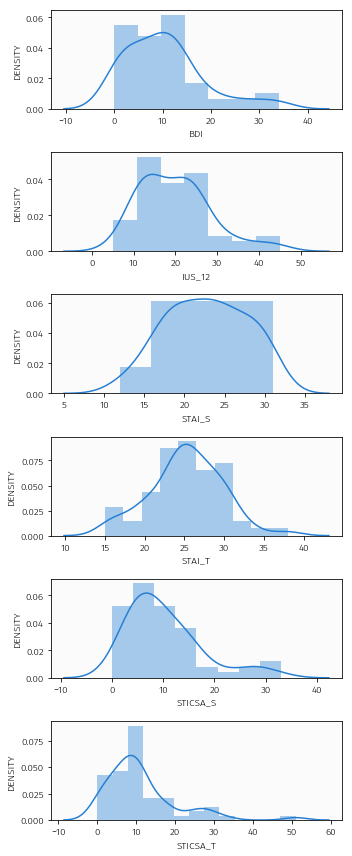

In [13]:
f, ax = plt.subplots(len(measure_names) - 1, figsize=(5, 12))

for n, measure in enumerate(measure_names):
    if measure != 'Sex':
        temp_data = group_df.filter(regex=measure).astype(int)
        group_df[measure + '_sum'] = temp_data.sum(axis=1)
        if measure == 'STICSA_T':
            # Compute STICSA subscales
            cognitive = temp_data[[c for c in temp_data.columns if not 'sum' in c and 
                                   int(re.search('\d+', c).group()) in sticsa_t_cognitive_qs]]
            somatic = temp_data[[c for c in temp_data.columns if not 'sum' in c and 
                                   int(re.search('\d+', c).group()) not in sticsa_t_cognitive_qs]]
            group_df[measure + '_cognitive_sum'] = cognitive.sum(axis=1)
            group_df[measure + '_somatic_sum'] = somatic.sum(axis=1)
        sns.distplot(group_df[measure + '_sum'], ax=ax[n], color=pal[0])
        ax[n].set_xlabel(measure, fontweight='light')
        ax[n].set_ylabel("DENSITY", fontweight='light')

plt.tight_layout()

# Save to csv
group_df.to_csv(os.path.join(data_dir, 'group_questionnaire_data.csv'), index=False)

In [14]:
group_df.age = group_df.age.astype(int)
print "N female = {0}".format(group_df.Sex_0.astype(int).sum())
print "Mean (SD) age = {0} ({1})".format(np.round(group_df.age.mean(), 2), np.round(group_df.age.std(), ))

N female = 38
Mean (SD) age = 26.7 (9.0)


## Load the data

Here we load the questionnaire data, the parameter values from our behavioural model and quantities derived from the model, and the results of the fixation analysis.

In [15]:
# Questionnaire data
questionnare_data = pd.read_csv('../data/questionnaire_data/group_questionnaire_data.csv')

# Individual subjects' parameter estimates from the model
param_values = pd.read_csv('../data/behavioural_data/group_param_values.csv')

# Mean quantities from the model, used to provide a measure of average uncertainty and value
mean_model_quantities = pd.read_csv('../data/behavioural_data/mean_model_quantities.csv')

# Combine these into a single dataframe
combined_df = pd.merge(param_values, questionnare_data, on='Subject')
combined_df = pd.merge(combined_df, mean_model_quantities, on='Subject')

combined_df.head()


,Subject,mean_$\lambda$,mean_$\omega$,mean_$\tau^+$,mean_$\tau^-$,sd_$\lambda$,sd_$\omega$,sd_$\tau^+$,sd_$\tau^-$,mc_error_$\lambda$,...,True_response,sim_model_input_0,$\lambda$_sim,$\omega$_sim,$\tau^+$_sim,$\tau^-$_sim,value_sim,alpha_sim,beta_sim,Response
0,2,0.020279,0.034126,0.392595,0.176883,0.015386,0.020580,0.128828,0.058641,0.000217,...,0.516407,0.356250,0.020279,0.034126,0.392595,0.176883,0.5,1.0,1.0,0.502604
1,5,0.060695,0.050115,0.707743,0.284449,0.019640,0.024146,0.143458,0.062024,0.000305,...,0.537950,0.359375,0.060695,0.050115,0.707743,0.284449,0.5,1.0,1.0,0.529390
2,8,0.016065,0.017938,0.284251,0.242456,0.013167,0.015057,0.091674,0.069731,0.000159,...,0.401398,0.359375,0.016065,0.017938,0.284251,0.242456,0.5,1.0,1.0,0.420569
3,9,0.058153,0.026118,0.337263,0.204239,0.020199,0.017742,0.108260,0.062932,0.000262,...,0.467444,0.359375,0.058153,0.026118,0.337263,0.204239,0.5,1.0,1.0,0.464965
4,11,0.425011,0.003290,0.039640,0.013597,0.021415,0.001661,0.020817,0.007091,0.000271,...,0.554957,0.359375,0.425011,0.003290,0.039640,0.013597,0.5,1.0,1.0,0.526238


Our parameter names have various special characters in them that bambi doesn't like, so we need to temporarily rename them. 

We're also going to standardise the predictors and outcome variable so they have zero mean and unit variance. 

In [16]:
# List predictors in dictionarys with old names as keys and new names as values
# Each dictionary is a separate list of predictors for a separate regression model
predictors = [{'$\lambda$_sim': 'lambda_', '$\omega$_sim': 'omega', r'$\tau^-$_sim': 'tau_n', 
              r'$\tau^+$_sim': 'tau_p', 'shock_rating': 'shock_rating'},
             {'True_response': 'reported_value', 'var': 'var', 'shock_rating': 'shock_rating'}]

# List of outcome measures
outcomes = ['STICSA_T_sum', 'STICSA_S_sum']

# Standardise things
from sklearn.preprocessing import scale
combined_df.loc[:, [c for c in combined_df if not 'Subject' in c]] = scale(combined_df[[c for c in combined_df if not 'Subject' in c]])

# rename predictor variables to remove weird characters
combined_df.columns = [predictors[0][i] if i in predictors[0] else i for i in combined_df.columns]
combined_df.columns = [predictors[1][i] if i in predictors[1] else i for i in combined_df.columns]

print "Number of subjects = {0}".format(len(combined_df))
print "Subject IDs = {0}".format(combined_df.Subject.values)

combined_df.to_csv('../data/questionnaire_data/questionnaire_combined_data.csv')


C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':


Number of subjects = 46
Subject IDs = [ 2  5  8  9 11 13 16 17 18 19 20 23 25 26 27 28 29 30 32 33 34 35 36 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 55 56 58 59 60 61 62]


## Construct and fit the models

Here we fit four Bayesian linear regression models:

1. Predicting state anxiety from model parameters
2. Predicting trait anxiety from model parameters
3. Predicting state anxiety from value and uncertainty estimates
4. Predicting trate anxiety from value and uncertainty estimates

Each model includes perceived shock unpleasantness as a covariate.

In [18]:
model_list = []
results_list = []

for n, outcome in enumerate(outcomes):
    model = Model(combined_df)
    results = model.fit(construct_equation(predictors[0], outcome), chains=1, samples=3000, tune=1000, init='jitter+adapt_diag')
    model_list.append(model)
    results_list.append(results)

for n, outcome in enumerate(outcomes):
    model = Model(combined_df)
    results = model.fit(construct_equation(predictors[1], outcome), chains=1, samples=3000, tune=1000, init='jitter+adapt_diag')
    model_list.append(model)
    results_list.append(results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [STICSA_T_sum_sd, tau_n, shock_rating, omega, lambda_, tau_p, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:21<00:00, 182.78it/s]
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\signal\signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\signal\signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
There was 1 divergence af

In [19]:
results_list[1].summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,0.001484,0.135817,-0.261712,0.265509,6000,0.999906
STICSA_S_sum_sd,0.924971,0.060066,0.812756,1.011008,4757,1.000143
lambda_,-0.063235,0.141523,-0.334922,0.217603,5403,0.999836
omega,-0.042172,0.133839,-0.304329,0.218186,5623,0.999863
shock_rating,0.106087,0.142401,-0.171160,0.384875,4940,0.999846
tau_n,0.667580,0.280134,0.141089,1.227466,2673,1.000372
tau_p,-0.408998,0.277373,-0.959975,0.122733,2641,0.999981


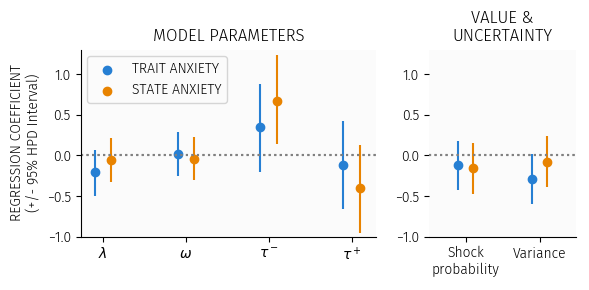

In [24]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib import gridspec
prop = font_manager.FontProperties(fname="C:\WINDOWS\Fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

# sns.set_style("white")

fig = plt.figure(figsize=(6, 3), dpi=100)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5]) 

for n, r in enumerate(results_list):
    
    ax = plt.subplot(gs[n / 2])

    summary = r.summary()

    predictor_names = []
    for i in summary.index.tolist():
        name = None
        for j, k in predictors[n / 2].iteritems():
            if k == i:
                name = j
        if name == None:
            name = i
        name = name.replace('True_response', 'Shock_probability')
        name = name.replace('shock_rating', 'Shock_intensity')
        name = name.replace('mean_', '')
        name = name.replace('var', 'Variance')
        if outcomes[n / 2] not in name:
            name = name.replace('_', '\n')
        name = name.replace('shock', 'Shock')
        name = name.replace('reported', 'Reported')
        predictor_names.append(name)

    summary['predictor'] = predictor_names
    df = summary[~summary.predictor.isin(['Intercept', 'Shock\nintensity'])]
    df = df[~df.index.str.contains('_sd')]
    
    ax.scatter(np.arange(0, len(df)) - 0.1 + (n % 2) * 0.2, 'mean', facecolors=pal[n % 2],
                  data=df, label=['TRAIT ANXIETY', 'STATE ANXIETY'][n % 2])
    
    ax.errorbar(np.arange(0, len(df)) - 0.1 + (n % 2) * 0.2, 'mean', yerr=[df['mean'] - df['hpd0.95_lower'], 
                                              df['hpd0.95_upper'] - df['mean']], 
                   fmt='none', label=None, ecolor=pal[n % 2],
                   data=df)
    ax.set_xticks(np.arange(len(df)))
    ax.set_xticklabels([i.replace('sim', '') for i in df.predictor], rotation=0)
    if n / 2 == 0:
        ax.set_ylabel("REGRESSION COEFFICIENT\n(+/- 95% HPD Interval)", fontweight='light')
        ax.legend(loc='upper left')
        sns.despine(ax=ax)
        ax.set_title("MODEL PARAMETERS", fontweight='light')
    else:
        sns.despine(left=True, ax=ax)
        ax.set_xlim(-0.5, 1.5)
        ax.set_title("VALUE &\nUNCERTAINTY", fontweight='light')
    ax.axhline(0, linestyle=':', c='grey')
    ax.set_ylim(-1, 1.3)

    
plt.tight_layout()

plt.savefig('../figures/anxiety_betas_parameters.svg', facecolor='#fbfbfb')

## Posterior predictive checks

In [25]:
ppc = pm.sample_ppc(model_list[1].backend.trace, model=model_list[1].backend.model, samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.00it/s]


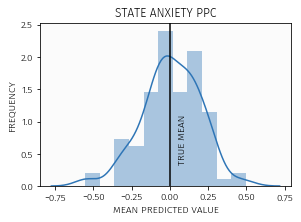

In [26]:
plt.figure(figsize=(4.5, 3))
sns.distplot([n.mean() for n in ppc['STICSA_S_sum']], color='#2e75b6')
plt.axvline(combined_df['STICSA_S_sum'].mean(), color='black')
plt.text(combined_df['STICSA_S_sum'].mean() + 0.05, 1, 'TRUE MEAN', rotation=90, fontweight='light')
plt.xlabel('MEAN PREDICTED VALUE', fontweight='light')
plt.ylabel('FREQUENCY', fontweight='light')
plt.title("STATE ANXIETY PPC", fontweight='light')

plt.savefig('../figures/anxiety_ppc.svg', facecolor='#fbfbfb')

This seems to work pretty well - as our data is centered the true mean of the outcome variable is zero, and the samples drawn from the posterior of our fitted model also have a mean of almost exactly zero.

# Relationship between model parameters and behaviour

Here we fit a simple linear model to predict mean reported value across from subjects from their parameter values. This allows us to look at how individual differences in model parameters relate to observed behaviour.

In [27]:
model = Model(combined_df)
results = model.fit(construct_equation(['tau_n', 'tau_p', 'lambda_'], 'reported_value'), chains=1, samples=3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 50.655:  28%|██████████████▋                                     | 14162/50000 [00:30<01:27, 408.63it/s]
Convergence achieved at 14200
Interrupted at 14,199 [28%]: Average Loss = 96.978
Sequential sampling (2 chains in 1 job)
NUTS: [reported_value_sd, lambda_, tau_p, tau_n, Intercept]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:21<00:00, 184.09it/s]


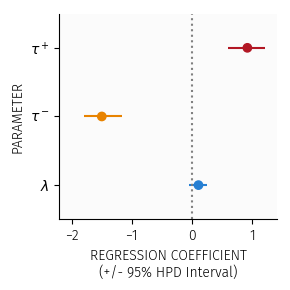

In [30]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
prop = font_manager.FontProperties(fname="C:\WINDOWS\Fonts/FiraSans-ExtraLight.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

pal = ['#267fd3', '#e88300', '#b21724', '#053c5e']

# sns.set_style("white")
ax = plt.figure(figsize=(3, 3), dpi=100)

summary = results.summary()
df = summary[~summary.index.isin(['Intercept', 'reported_value_sd'])]

ax = plt.scatter('mean', np.arange(0, len(df)), facecolors=pal,
              data=df)
plt.errorbar('mean', np.arange(0, len(df)), xerr=[df['mean'] - df['hpd0.95_lower'], 
                                          df['hpd0.95_upper'] - df['mean']], 
               fmt='none', label=None, ecolor=pal,
               data=df)
plt.yticks(np.arange(0, len(df)), ['$\\tau^+$', '$\\tau^-$', '$\lambda$'][::-1])
plt.ylabel("PARAMETER", fontweight='light')
plt.xlabel("REGRESSION COEFFICIENT\n(+/- 95% HPD Interval)", fontweight='light')
plt.axvline(0, linestyle=':', c='grey')
plt.ylim(-0.5, 2.5)
plt.xlim(-2.2, 1.4)

sns.despine()
    
plt.tight_layout()

plt.savefig('../figures/shock_probability_prediction.svg', facecolor='#fbfbfb')

In [28]:
results.summary()

,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
Intercept,-0.001137,0.077241,-0.154584,0.150219,5543,0.999882
lambda_,0.105549,0.075392,-0.050639,0.248573,5500,1.000064
reported_value_sd,0.527516,0.060533,0.411492,0.645311,4804,1.000772
tau_n,-1.498370,0.157314,-1.791489,-1.170412,1954,1.000454
tau_p,0.916663,0.156395,0.594194,1.206098,1929,1.000567
